### 1.1 回归与插值

### 1.1.1 线性回归

In [1]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath('../'))
from market import market_wrapper

btc_df = market_wrapper.create_k_data('BTC')
btc_close = btc_df.close
x = np.arange(0, btc_close.shape[0])
# 收盘价格序列
y = btc_close.values
x

array([   0,    1,    2, ..., 1487, 1488, 1489])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     120.0
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           6.55e-27
Time:                        08:31:52   Log-Likelihood:                -16393.
No. Observations:                1490   AIC:                         3.279e+04
Df Residuals:                    1488   BIC:                         3.280e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.203e+04    752.187     29.287      0.000    2.06e+04    2.35e+04
x1             9.5830      0.875     10.954      0.000       7.867      11.299
==============================================================================
Omnibus:                      154.182   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.267
Skew:                           0.833   Prob(JB):                     9.70e-41
Kurtosis:                       2.558   Cond. No.                     1.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

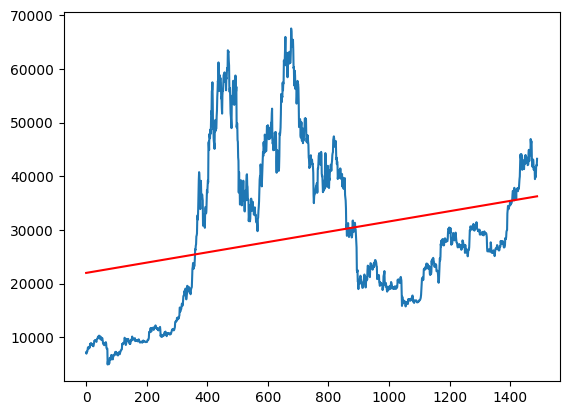

In [2]:
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt

def regress_y(y):
    y = y
    # x序列: 0，1，2, ...len(y)
    x = np.arange(0, len(y))
    x = sm.add_constant(x)
    # 使用OLS做拟合
    model = regression.linear_model.OLS(y, x).fit()
    return model


model = regress_y(y)
b = model.params[0]
k = model.params[1]
# y = kx + b
y_fit = k * x + b
plt.plot(x, y)
plt.plot(x, y_fit, 'r')
# summary模型拟合概述，表6-1所示
model.summary()

In [5]:
MAE = sum(np.abs(y - y_fit)) / len(y)
print('偏差绝对值之和(MAE)={}'.format(MAE))

偏差绝对值之和(MAE)=12447.229556891412


In [6]:
MSE = sum(np.square(y - y_fit)) / len(y)
print('偏差绝对值之和(MSE)={}'.format(MSE))

偏差绝对值之和(MSE)=210683817.6032021


In [7]:
RMSE = np.sqrt(sum(np.square(y - y_fit)) / len(y))
print('偏差绝对值之和(RMSE)={}'.format(RMSE)) 

偏差绝对值之和(RMSE)=14514.951519147493


In [9]:
from sklearn import metrics

print('sklearn偏差绝对值之和(MAE)={}'.format(metrics.mean_absolute_error(y, y_fit))) 
print('sklearn偏差平方(MSE)={}'.format(metrics.mean_squared_error(y, y_fit)))
print('sklearn偏差平方和开平方(RMSE)={}'.format(np.sqrt(metrics.mean_squared_error(y, y_fit))))

sklearn偏差绝对值之和(MAE)=12447.229556891412
sklearn偏差平方(MSE)=210683817.60320243
sklearn偏差平方和开平方(RMSE)=14514.951519147504


### 1.1.2 多项式回归

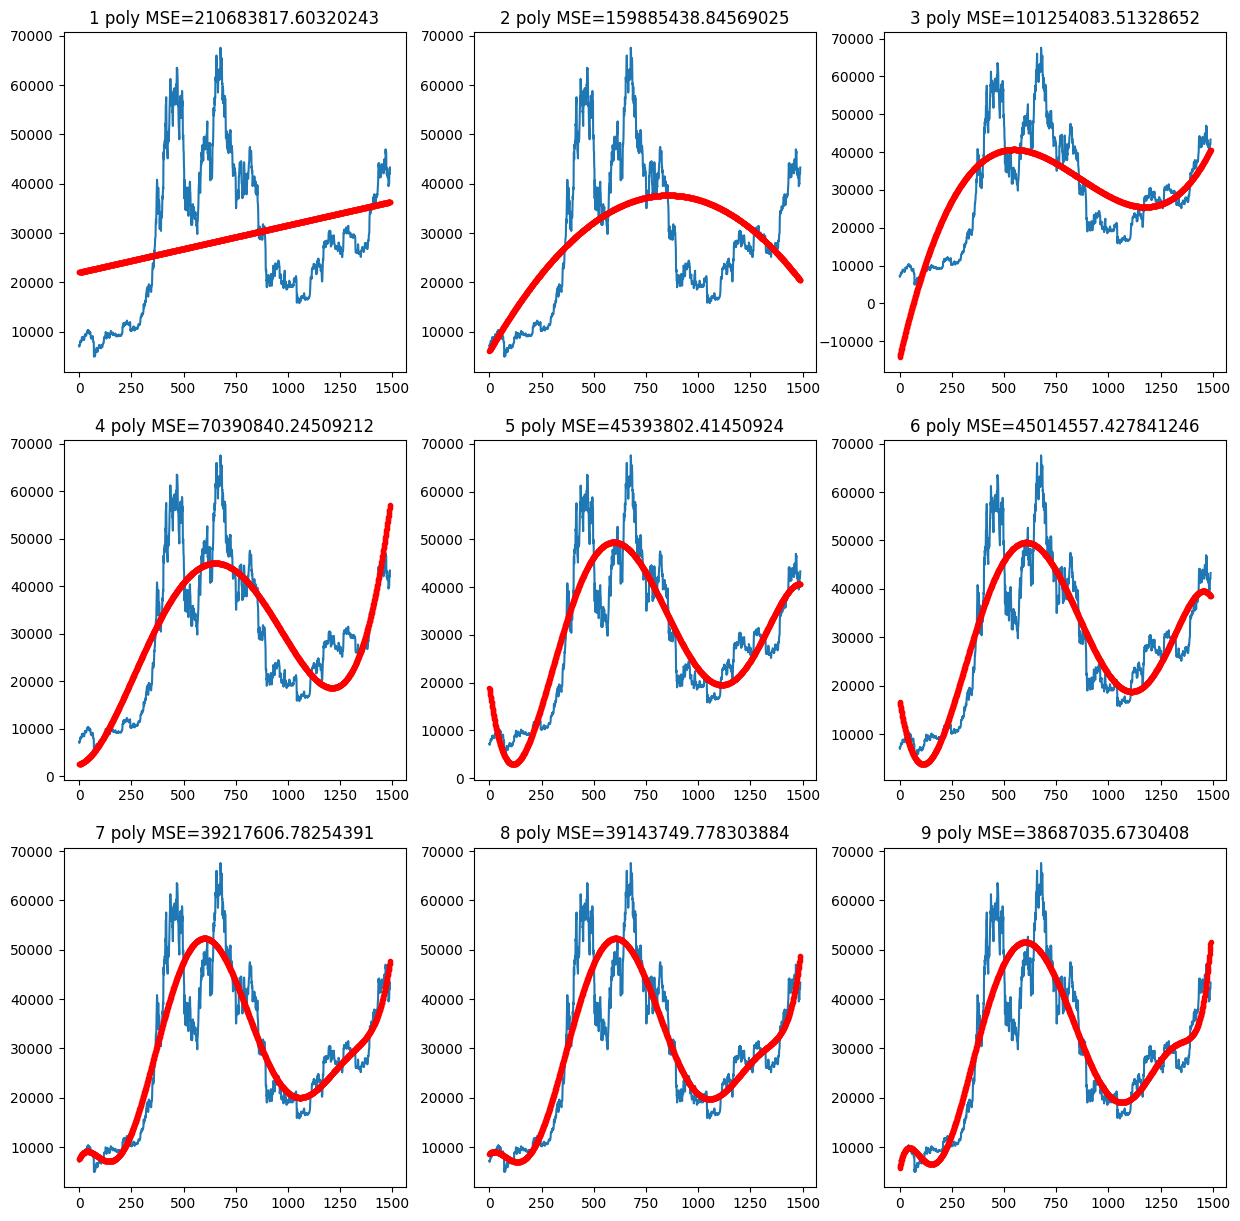

In [10]:
import itertools

# 生成9个subplots 3*3
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# 将 3 * 3转换成一个线性list
axs_list = list(itertools.chain.from_iterable(axs))
# 1-9次多项式回归
poly = np.arange(1, 10, 1)
for p_cnt, ax in zip(poly, axs_list):
    # 使用polynomial.Chebyshev.fit进行多项式拟合
    p = np.polynomial.Chebyshev.fit(x, y, p_cnt)
    # 使用p直接对x序列代人即得到拟合结果序列
    y_fit = p(x)
    # 度量mse值
    mse = metrics.mean_squared_error(y, y_fit)
    # 使用拟合次数和mse误差大小设置标题
    ax.set_title('{} poly MSE={}'.format(p_cnt, mse))
    ax.plot(x, y, '', x, y_fit, 'r.')

### 1.1.3 Interpolation

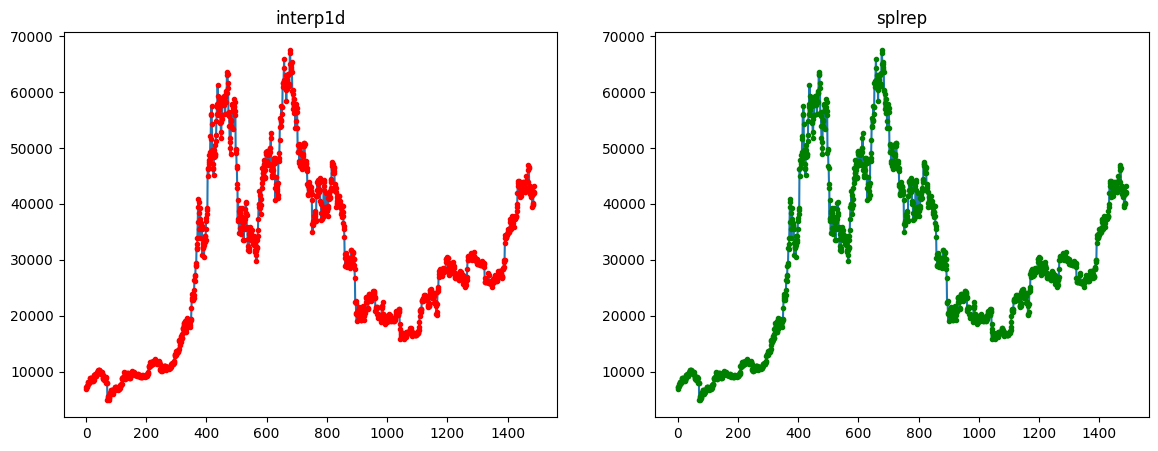

In [11]:
from scipy.interpolate import interp1d, splrep, splev

# 示例两种插值计算方式
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# 线性插值
linear_interp = interp1d(x, y)
# axs[0]左边的
axs[0].set_title('interp1d')
# 在相同坐标系下，同样的x，插值的y值使r.绘制（红色点）
axs[0].plot(x, y, '', x, linear_interp(x), 'r.')

# B-spline插值
splrep_interp = splrep(x, y)
# axs[1]右边的
axs[1].set_title('splrep')
# #在相同坐标系下，同样的x，插值的y值使g.绘制（绿色点）
axs[1].plot(x, y, '', x, splev(x, splrep_interp), 'g.');

## 1.2 蒙特卡洛方法与凸优化

In [12]:
from abc import ABC, ABCMeta, abstractmethod

# 每个人平均寿命期望是75年，约75*365=27375天
K_INIT_LIVING_DAYS = 27375

class Person(object):
    """
        人类
    """

    def __init__(self):
        # 初始化人平均能活的寿命
        self.living = K_INIT_LIVING_DAYS
        # 初始化幸福指数
        self.happiness = 0
        # 初始化财富值
        self.wealth = 0
        # 初始化名望权利
        self.fame = 0
        # 活着的第几天
        self.living_day = 0

    def live_one_day(self, seek):
        """
        每天只能进行一个seek，这个seek决定了你今天追求的是什么，得到了什么
        seek的类型属于下面将编写的BaseSeekDay
        :param seek:
        :return:
        """
        # 调用每个独特的BaseSeekDay类都会实现的do_seek_day，得到今天的收获
        consume_living, happiness, wealth, fame = seek.do_seek_day()
        # 每天要减去生命消耗，有些seek前面还会增加生命
        self.living -= consume_living
        # seek得到的幸福指数积累
        self.happiness += happiness
        # seek得到的财富积累
        self.wealth += wealth
        # seek得到的名望权力积累
        self.fame += fame
        # 活完这一天了
        self.living_day += 1

In [13]:
class BaseSeekDay(ABC):
    def __init__(self):
        # 每个追求每天消耗生命的常数
        self.living_consume = 0

        # 每个追求每天幸福指数常数
        self.happiness_base = 0

        # 每个追求每天财富积累常数
        self.wealth_base = 0
        # 每个追求每天名望权利积累常数
        self.fame_base = 0

        # 每个追求每天消耗生命的可变因素序列
        self.living_factor = [0]

        # 每个追求每天幸福指数的可变因素序列
        self.happiness_factor = [0]

        # 每个追求每天财富积累的可变因素序列
        self.wealth_factor = [0]
        # 每个追求每天名望权利的可变因素序列
        self.fame_factor = [0]

        # 追求了多少天了这一生
        self.do_seek_day_cnt = 0
        # 子类进行常数及可变因素序列设置
        self._init_self()

    @abstractmethod
    def _init_self(self, *args, **kwargs):
        # 子类必须实现，设置自己的生命消耗的常数，幸福指数常数等常数设置
        pass

    @abstractmethod
    def _gen_living_days(self, *args, **kwargs):
        # 子类必须实现，设置自己的可变因素序列
        pass

    def do_seek_day(self):
        """
        每一天的追求具体seek
        :return:
        """
        # 生命消耗=living_consume:消耗常数 * happiness_factor:可变序列
        if self.do_seek_day_cnt >= len(self.living_factor):
            # 超出len(self.living_factor), 就取最后一个living_factor[-1]
            consume_living = \
                self.living_factor[-1] * self.living_consume
        else:
            # 每个类自定义这个追求的消耗生命常数，以及living_factor，比如
            # HealthSeekDay追求健康，living_factor序列的值即由负值->正值
            # 每个子类living_factor会有自己特点的变化速度及序列长度，导致每个
            # 追求对生命的消耗随着追求的次数变化不一
            consume_living = self.living_factor[self.do_seek_day_cnt] \
                             * self.living_consume
        # 幸福指数=happiness_base:幸福常数 * happiness_factor:可变序列
        if self.do_seek_day_cnt >= len(self.happiness_factor):
            # 超出len(self.happiness_factor), 就取最后一个
            # 由于happiness_factor值由:n—>0 所以happiness_factor[-1]=0
            # 即随着追求一个事物的次数过多后会变的没有幸福感
            happiness = self.happiness_factor[
                            -1] * self.happiness_base
        else:
            # 每个类自定义这个追求的幸福指数常数，以及happiness_factor
            # happiness_factor子类的定义一般是从高－>低变化
            happiness = self.happiness_factor[
                            self.do_seek_day_cnt] * self.happiness_base
        # 财富积累=wealth_base:积累常数 * wealth_factor:可变序列
        if self.do_seek_day_cnt >= len(self.wealth_factor):
            # 超出len(self.wealth_factor), 就取最后一个
            wealth = self.wealth_factor[-1] * self.wealth_base
        else:
            # 每个类自定义这个追求的财富指数常数，以及wealth_factor
            wealth = self.wealth_factor[
                         self.do_seek_day_cnt] * self.wealth_base
        # 权利积累=fame_base:积累常数 * fame_factor:可变序列
        if self.do_seek_day_cnt >= len(self.fame_factor):
            # 超出len(self.fame_factor), 就取最后一个
            fame = self.fame_factor[-1] * self.fame_base
        else:
            # 每个类自定义这个追求的名望权利指数常数，以及fame_factor
            fame = self.fame_factor[
                       self.do_seek_day_cnt] * self.fame_base
        # 追求了多少天了这一生 + 1
        self.do_seek_day_cnt += 1
        # 返回这个追求这一天对生命的消耗，得到的幸福，财富，名望权利
        return consume_living, happiness, wealth, fame

In [14]:
def regular_mm(group):
    # 最小-最大规范化
    return (group - group.min()) / (group.max() - group.min())


class HealthSeekDay(BaseSeekDay):
    """
        HealthSeekDay追求健康长寿的一天:
        形象：健身，旅游，娱乐，做感兴趣的事情。
        抽象：追求健康长寿。
    """

    def _init_self(self):
        # 每天对生命消耗的常数＝1，即代表1天
        self.living_consume = 1
        # 每天幸福指数常数＝1
        self.happiness_base = 1
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成12000个序列，因为下面的happiness_factor序列值由1－>0
        # 所以大于12000次的追求都将只是单纯消耗生命，并不增加幸福指数
        # 即随着做一件事情的次数越来越多，幸福感越来越低，直到完全体会不到幸福
        days = np.arange(1, 12000)
        # 基础函数选用sqrt, 影响序列变化速度
        living_days = np.sqrt(days)

        """
            对生命消耗可变因素序列值由-1->1, 也就是这个追求一开始的时候对生命
            的消耗为负增长，延长了生命，随着追求的次数不断增多对生命的消耗转为正
            数因为即使一个人天天锻炼身体，天天吃营养品，也还是会有自然死亡的那
            一天
        """
        # *2-1的目的:regular_mm在0-1之间,HealthSeekDay要结果在－1，1之间
        self.living_factor = regular_mm(living_days) * 2 - 1
        # 结果在1-0之间 [::-1]: 将0->1转换到1->0
        self.happiness_factor = regular_mm(days)[::-1]

In [15]:
# 初始化我, 你一生的故事：HealthSeekDay
me = Person()
# 初始化追求健康长寿快乐
seek_health = HealthSeekDay()
while me.living > 0:
    # 只要还活着，就追求健康长寿快乐
    me.live_one_day(seek_health)

print('只追求健康长寿快乐活了{}年，幸福指数{},积累财富{},名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       me.wealth, me.fame))

只追求健康长寿快乐活了97.12年，幸福指数5999.5,积累财富0,名望权力0


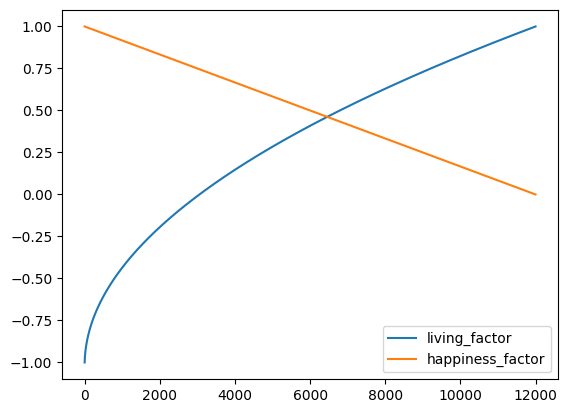

In [16]:
plt.plot(seek_health.living_factor * seek_health.living_consume)
plt.plot(seek_health.happiness_factor * seek_health.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')

In [17]:
class StockSeekDay(BaseSeekDay):
    """
        StockSeekDay追求财富金钱的一天:
        形象：做股票投资赚钱的事情。
        抽象：追求财富金钱
    """

    def _init_self(self, show=False):
        # 每天对生命消耗的常数＝2，即代表2天
        self.living_consume = 2
        # 每天幸福指数常数＝0.5
        self.happiness_base = 0.5
        # 财富积累常数＝10，默认＝0
        self.wealth_base = 10
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成10000个序列
        days = np.arange(1, 10000)
        # 针对生命消耗living_factor的基础函数还是sqrt
        living_days = np.sqrt(days)
        # 由于不需要像HealthSeekDay从负数开始，所以直接regular_mm 即:0->1
        self.living_factor = regular_mm(living_days)
        
        # 针对幸福感可变序列使用了np.power4，即变化速度比sqrt快
        happiness_days = np.power(days, 4)
        # 幸福指数可变因素会快速递减由1->0
        self.happiness_factor = regular_mm(happiness_days)[::-1]
        
        """
            这里简单设定wealth_factor=living_factor
            living_factor(0-1), 导致wealth_factor(0-1), 即财富积累越到
            后面越有效率，速度越快，头一个100万最难赚
        """
        self.wealth_factor = self.living_factor

In [18]:
# 初始化我, 你一生的故事：StockSeekDay
me = Person()
# 初始化追求财富金钱
seek_stock = StockSeekDay()
while me.living > 0:
    # 只要还活着，就追求财富金钱
    me.live_one_day(seek_stock)

print('只追求财富金钱活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       round(me.wealth, 2), me.fame))

只追求财富金钱活了46.72年，幸福指数-20886245.69, 积累财富136878.35, 名望权力0


C:\Users\uncczhangtao\AppData\Local\Temp\ipykernel_37012\3290420311.py:3: RuntimeWarning: overflow encountered in scalar subtract
  return (group - group.min()) / (group.max() - group.min())


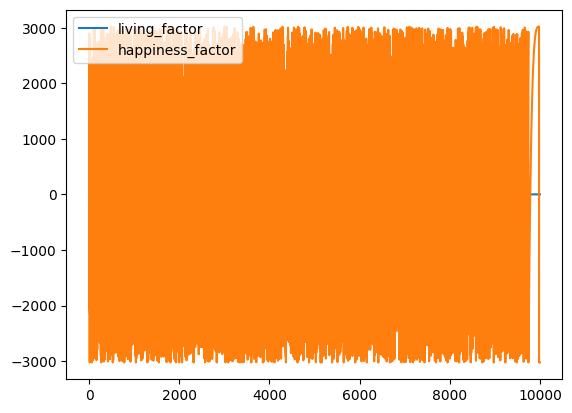

In [19]:
plt.plot(seek_stock.living_factor * seek_stock.living_consume)
plt.plot(seek_stock.happiness_factor * seek_stock.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')

In [20]:
class FameSeekDay(BaseSeekDay):
    """
        FameTask追求名望权力的一天:
        追求名望权力
    """

    def _init_self(self):
        # 每天对生命消耗的常数＝3，即代表3天
        self.living_consume = 3
        # 每天幸福指数常数＝0.6
        self.happiness_base = 0.6
        # 名望权利积累常数＝10，默认＝0
        self.fame_base = 10
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成12000个序列
        days = np.arange(1, 12000)
        # 针对生命消耗living_factor的基础函数还是sqrt
        living_days = np.sqrt(days)
        # 由于不需要像HealthSeekDay从负数开始，所以直接regular_mm 即:0->1
        self.living_factor = regular_mm(living_days)

        # 针对幸福感可变序列使用了np.power2
        # 即变化速度比StockSeekDay慢但比HealthSeekDay快
        happiness_days = np.power(days, 2)
        # 幸福指数可变因素递减由1->0
        self.happiness_factor = regular_mm(happiness_days)[::-1]

        # 这里简单设定fame_factor=living_factor
        self.fame_factor = self.living_factor

In [21]:
# 初始化我, 你一生的故事：FameSeekDay
me = Person()
# 初始化追求名望权力
seek_fame = FameSeekDay()
while me.living > 0:
    # 只要还活着，就追求名望权力
    me.live_one_day(seek_fame)

print('只追求名望权力活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       round(me.wealth, 2), round(me.fame, 2)))

只追求名望权力活了36.06年，幸福指数2400.1, 积累财富0, 名望权力91259.86


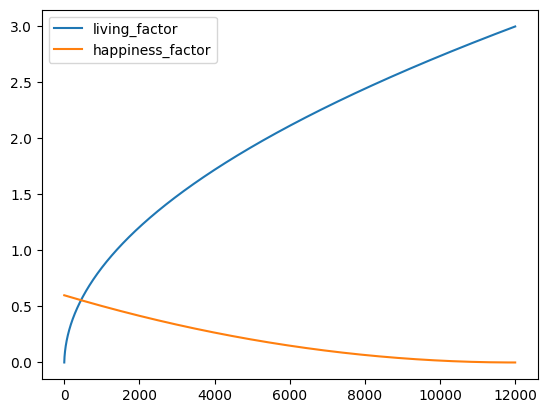

In [22]:
plt.plot(seek_fame.living_factor * seek_fame.living_consume)
plt.plot(seek_fame.happiness_factor * seek_fame.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best');

### 1.2.2 使用蒙特卡洛方法计算怎样度过一生最幸福

In [23]:
def my_life(weights):
    """
        追求健康长寿快乐的权重:weights[0]
        追求财富金钱的权重:weights[1]
        追求名望权力的权重:weights[2]
    """
    # 追求健康长寿快乐
    seek_health = HealthSeekDay()
    # 追求财富金钱
    seek_stock = StockSeekDay()
    # 追求名望权力
    seek_fame = FameSeekDay()

    # 放在一个list中对对应下面np.random.choice中的index[0, 1, 2]
    seek_list = [seek_health, seek_stock, seek_fame]

    # 初始化我
    me = Person()
    # 加权随机抽取序列。80000天肯定够了, 80000天快220年了。。。
    seek_choice = np.random.choice([0, 1, 2], 80000, p=weights)

    while me.living > 0:
        # 追求从加权随机抽取序列已经初始化好的
        seek_ind = seek_choice[me.living_day]
        seek = seek_list[seek_ind]
        # 只要还活着，就追求
        me.live_one_day(seek)
    return round(me.living_day / 365, 2), round(me.happiness, 2), \
        round(me.wealth, 2), round(me.fame, 2)

In [24]:
living_day, happiness, wealth, fame = my_life([0.4, 0.3, 0.3])
print('活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format(
    living_day, happiness, wealth, fame))

活了76.4年，幸福指数43810.74, 积累财富50471.78, 名望权力47699.53


C:\Users\uncczhangtao\AppData\Local\Temp\ipykernel_37012\3290420311.py:3: RuntimeWarning: overflow encountered in scalar subtract
  return (group - group.min()) / (group.max() - group.min())


In [25]:
weights = np.random.random(3)
weights /= np.sum(weights)
weights

array([0.51848793, 0.35351592, 0.12799615])

In [29]:
import random

# 目标函数，这里我们使用一个简单的线性函数作为示例
def target_function(x, a, b):
    return a * x + b

# 计算目标函数的误差，这里我们使用均方误差
def mean_squared_error(predictions, targets):
    return sum((p - t) ** 2 for p, t in zip(predictions, targets)) / len(targets)

# 模拟数据集
random.seed(42)  # 设置随机种子以使结果可重现
true_a = 2.0
true_b = 1.0
data_x = [random.uniform(0, 10) for _ in range(50)]  # 生成50个随机数据点
data_y = [target_function(x, true_a, true_b) + random.normalvariate(0, 1) for x in data_x]  # 添加噪声

# 定义蒙特卡罗参数搜索范围
num_iterations = 1000  # 迭代次数
best_a, best_b = None, None
best_error = float('inf')

for _ in range(num_iterations):
    # 随机选择参数
    random_a = random.uniform(0, 5)
    random_b = random.uniform(0, 5)
    
    # 计算预测值
    predicted_y = [target_function(x, random_a, random_b) for x in data_x]
    
    # 计算均方误差
    error = mean_squared_error(predicted_y, data_y)
    
    # 如果找到更好的参数，就更新最佳参数
    if error < best_error:
        best_a, best_b = random_a, random_b
        best_error = error

print("最佳参数:")
print(f"a = {best_a}")
print(f"b = {best_b}")
print(f"均方误差 = {best_error}")


最佳参数:
a = 2.0744226371840346
b = 0.49510817355264247
均方误差 = 0.864641069269995
